# Parte 1:


Luego de haber ejecutado la simulación del RoMAA en gazebo y haber capturado los datos de odometría y del lidar en dos archivos de texto, se procede a leer esa información y almacenarla en formatos mas convenientes para su uso. 

Los mismos son leídos en la siguiente celda.

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import math
from IPython.display import Image


odom_data = open("odom.txt","r")
scan_data = open("scan.txt","r")

odom_timestamps = []
odom_measures   = []
odom_x = []
odom_y = []
odom_theta      = []

scan_timestamps = []
scan_values   = []
scan_x = []
scan_y = []
scan_angles = []
datos = []

Se define una funcion que lee el objeto de archivo de odometría pose().

In [69]:
# la funcion pose lee el archivo de odometría para extraer los valores x,y,theta y retornar una lista
# compuesta por 3 listas: cada una de las listas almacena los valores de cada una de las variables x,y,theta

def pose(data):
    out = []
    elements = [] 
    pose  = []
    x     = []
    y     = []
    theta = []
    raw_data_line = []

    for line in data:                        # leo cada una de las lineas del objeto data resultante de la lectura del archivo
        elements = line.strip().split('\t')  # separo los elementos de cada linea. el separador es el caracter \t
        elements = list(map(float,elements)) # convierto la lista de str a float para poder trabajar con los elementos
        raw_data_line.append(elements)       # lista que contiene cada una las listas que contienen los datos de cada linea del archivo. A esta lista despues la tengo que analizar y extraer los elementos que correspondan
        
    time_stamps = [e[0] for e in raw_data_line] # extraigo los timestamps de raw_data_line y los almaceno en time_stamps que es una lista
    x = [e[1] for e in raw_data_line]           # idem que arriba pero para las coordenadas de x
    y = [e[2] for e in raw_data_line]           # idem que arriba pero para las coordenadas de y 
    theta = [e[3] for e in raw_data_line]       # lo mismo pero para theta
    out = [time_stamps,x,y,theta]
    
    
    
    return out                                  #retorna una lista con los datos diferenciados


Una vez definida la función, almacenamos los valores en una lista para timestamps, otra de coordenadas x de odometria
y de coordenadas y de odometría. También se obtiene una lista de cada ángulo $\theta$

In [70]:
odom_timestamps,odom_x,odom_y,theta = pose(odom_data)

print(len(odom_timestamps),len(odom_x),len(odom_y),len(theta))

print(odom_timestamps[0],odom_x[0],odom_y[0],theta[0])

3389 3389 3389 3389
1897.486 -0.92101 -0.25967 -1.73731


Como su nombre lo indica, se encarga de procesar la información del archivo de mediciones del sensor. Cada linea posee un timestamp y 540 mediciones, por lo que estos datos se almacenarán en una lista de timestamps y otra lista de listas de mediciones. Los angulos de cada medición son dados de manera implícita, por lo que pueden ser generados con los datos del sensor.

In [71]:
def lidar(data):
    out = []
    values = []
    x = []
    y = []
    raw_data_line = []

    angles = np.linspace((-3/4)*np.pi, (3/4)*np.pi, 540)
    for line in data:
        elements = line.strip().split('\t')
        elements = list(map(float,elements))
        raw_data_line.append(elements)
        #values.append(raw_data_line[1:541])      
    time_stamps =  [e[0] for e in raw_data_line]
    values      =  [e[1:] for e in raw_data_line] #values es una lista que contiene listas. Cada una de ellas posee las 540 mediciones del lidar
    

    return time_stamps,values,angles


In [72]:
scan_timestamps = []
v  = []
a  = []

scan_timestamps,v,a = lidar(scan_data)

Se pueden graficar diferentes los puntos medidos por el lidar en diferentes instantes de tiempo de la siguiente manera:

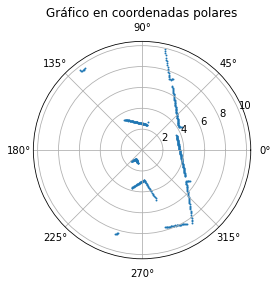

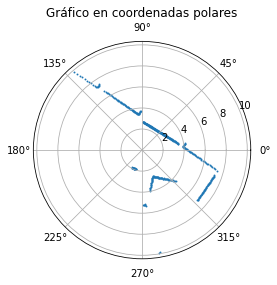

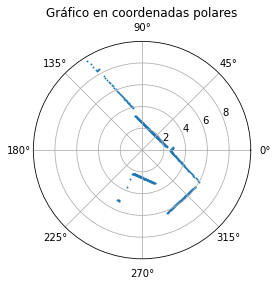

In [73]:
archivo = open("scan.txt", "r")


for linea in archivo:
    elementos = linea.strip().split('\t')
    datos_linea = []

    for elemento in elementos:
        datos_linea.append(float(elemento))

    datos.append(datos_linea)

archivo.close()

indice_linea = 100  # Índice de la línea que deseas graficar

for i in range(3):
    angle = np.linspace((-3/4)*np.pi, (3/4)*np.pi, len(datos[indice_linea+2*i][1:]))
    r = datos[indice_linea+20*i][1:]

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, polar=True)

    ax.scatter(angle, r,s=0.8)
    ax.set_title("Gráfico en coordenadas polares")
    ax.grid(True)

    plt.show()


In [74]:
odom_data.close()  # Cerrar el archivo después de leerlo
scan_data.close()  # Cerrar el archivo después de leerlo

# Parte 2

Habiendo obtenido los datos de la simulación, se debe realizar la sincronización de los datos de odometria con los del sensor, debido a la diferencia de tiempos de publicación de los datos de cada uno.

Es por esto que deberá diseñarse un algoritmo que emplee los arreglos unidimensionales de timestamps obtenidos anteriormente y determine los índices del vector de timestamp de odometría que se encuentran más próximos a los valores del vector de timestamp de las mediciones del laser, descartando los demás. 

Para ello se define la siguiente función:

In [75]:
odom_c = []

def find_nearest_timestamps(odometry_timestamps, laser_timestamps):
    nearest_indices = []
    odometry_timestamps = np.array(odometry_timestamps)  # Convertir a arreglo numpy
    laser_timestamps    = np.array(laser_timestamps)
    for laser_timestamp in laser_timestamps:
        nearest_index = np.abs(odometry_timestamps - laser_timestamp).argmin()
        nearest_indices.append(nearest_index)
    return nearest_indices

El resultado puede observarse gráficamente en la siguiente figura:

[1897.566, 1897.646, 1897.766, 1897.846, 1897.966, 1898.046, 1898.166, 1898.246, 1898.246, 1898.246]


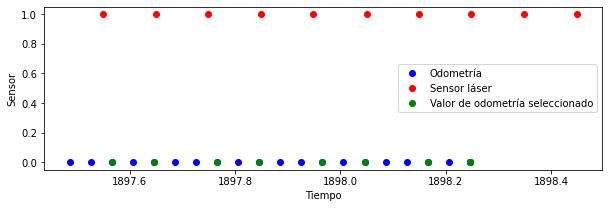

In [76]:
nearest_indices = find_nearest_timestamps(odom_timestamps[:20], scan_timestamps[:10])

# Gráfico de los instantes de tiempo
plt.figure(figsize=(10, 3))
plt.plot(odom_timestamps[:20], np.zeros_like(odom_timestamps[:20]), 'bo', label='Odometría')
plt.plot(scan_timestamps[:10], np.ones_like(scan_timestamps[:10]), 'ro', label='Sensor láser')

for idx in nearest_indices:
    odom_c.append(odom_timestamps[idx])

print(odom_c[:10])

# Resaltar los instantes de tiempo más cercanos
plt.plot(odom_c,np.zeros_like(odom_c), 'go',label='Valor de odometría seleccionado')

plt.xlabel('Tiempo')
plt.ylabel('Sensor')
plt.legend()
plt.show()

# Parte 3

Para la generación del mapa se requiere transformar las coordenadas de los puntos del laser, que se encuentran referidas a un marco de referencia móvil, sobre el robot, a otro marco de referencia global, fijo. Esto puede ser graficado de la siguiente manera:


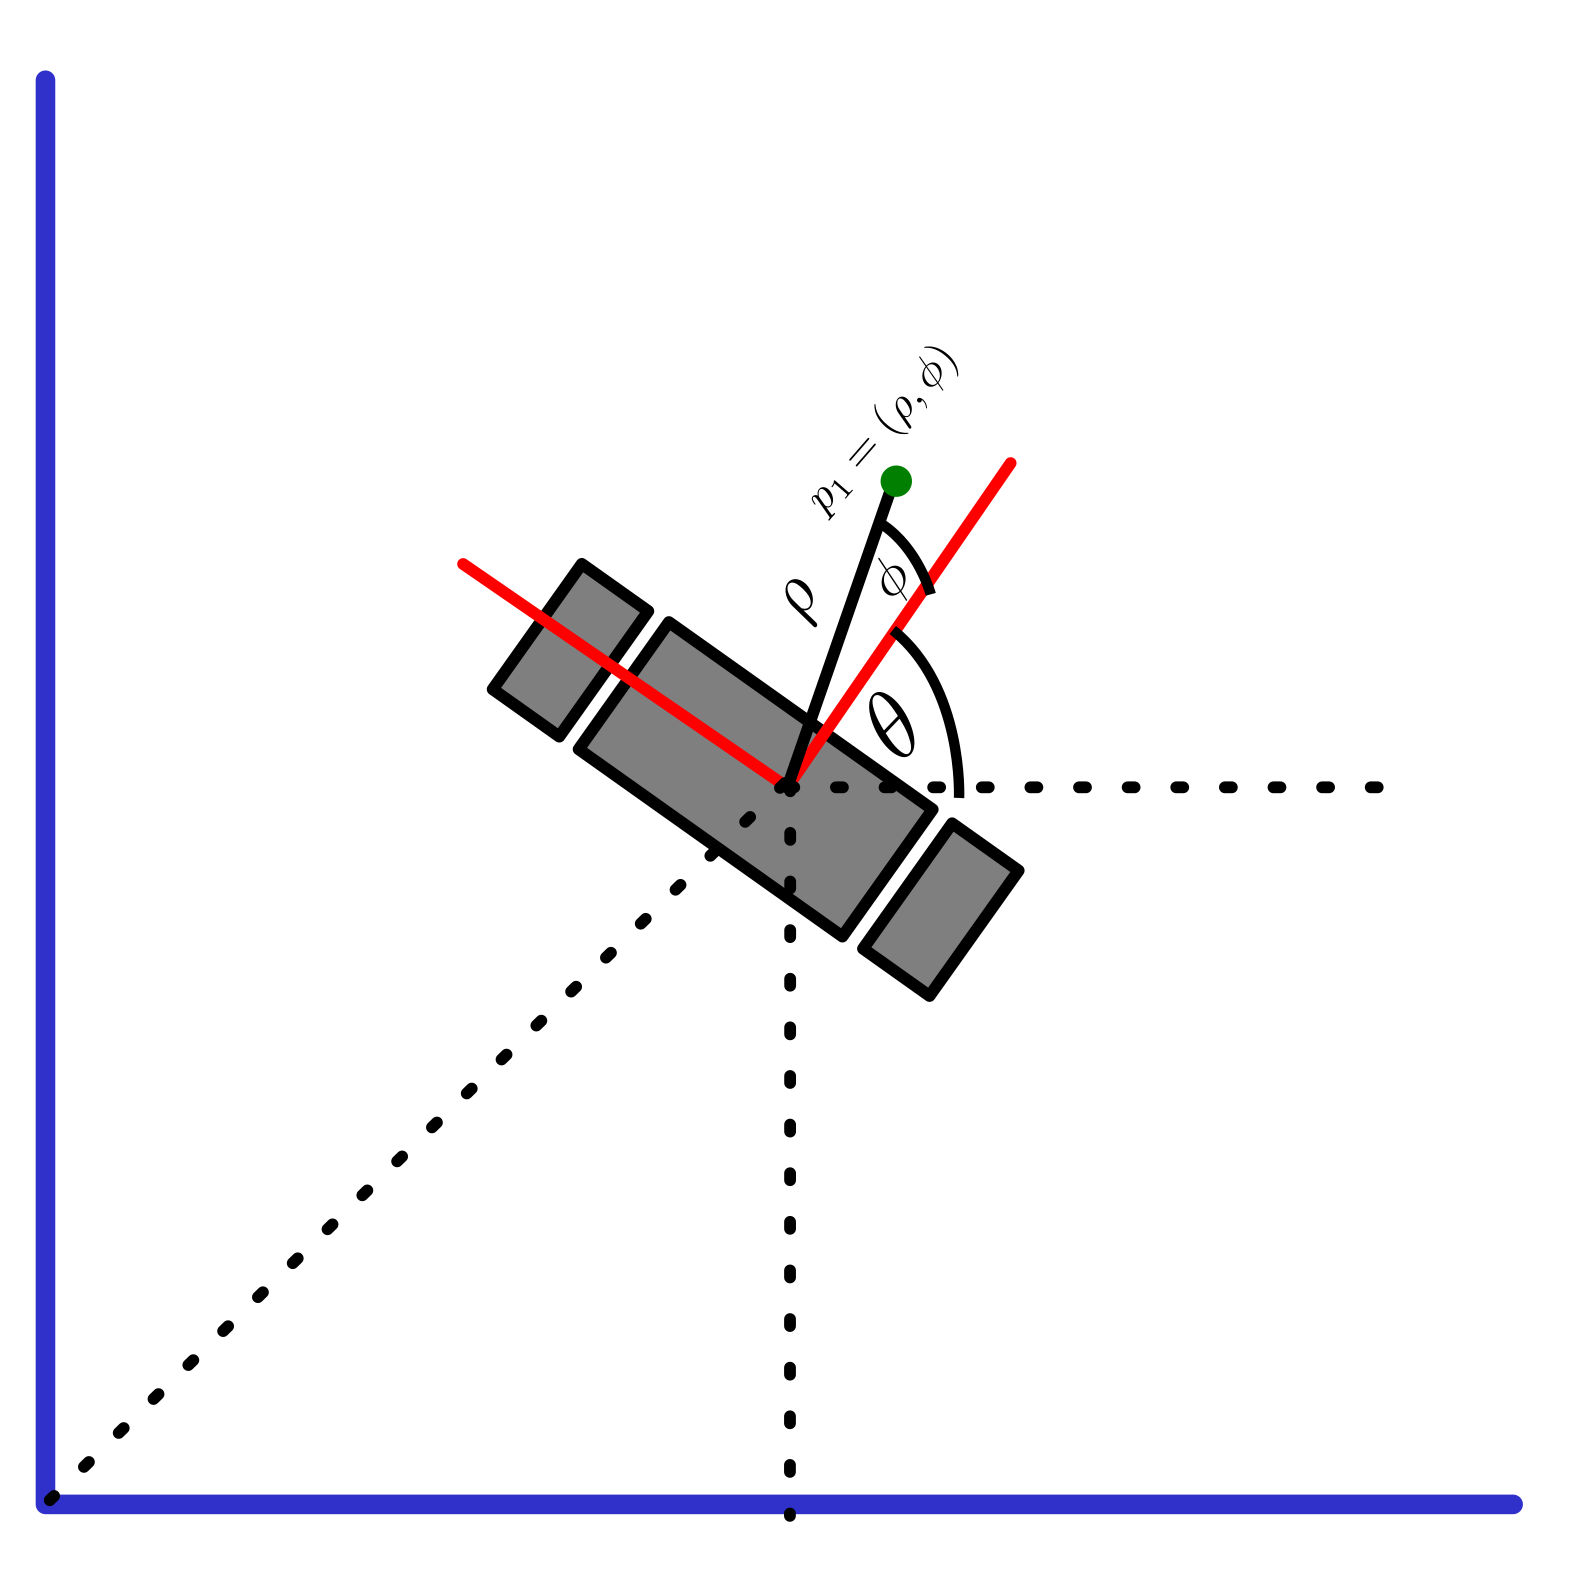

In [79]:
Image(filename='diagrama.png')


Esto puede ser resuelto realizando una suma vectorial entre el vector formado por el origen de coordenadas del mapa y el punto de odometría del robot y el vector formado por el origen de coordenadas del marco de referencia del lidar y el punto de medición a analizar. Es decir, el punto medido por el LIDAR tendrá las siguientes coordenadas referidas al origen de coordenadas del simulador:

$$x_c = x_{odom} + \rho \cdot cos(\theta+\phi)$$
$$y_c = y_{odom} + \rho \cdot sen(\theta+\phi)$$


Por otro lado se necesitará realizar la sincronización de las mediciones de odometría y el LIDAR, como se mencionó arriba. Por lo tanto empleando la función antes descrita, se filtran los valores necesarios y se descarta el resto.

In [64]:
nearest_indices = find_nearest_timestamps(odom_timestamps, scan_timestamps)
odom_xf =[]
odom_yf =[]
theta_f=[]

for idx in nearest_indices:
    
    odom_xf.append(odom_x[idx])
    odom_yf.append(odom_y[idx])
    theta_f.append(theta[idx])


La siguiente función implementa la conversión de coordenadas necesaria para cada punto:

In [80]:
def tr_base(odom_x, odom_y, scan_values, theta_f):
    x_c = []  # lista donde se almacenan las coordenadas en x
    y_c = []  # lista donde se almacenan las coordenadas en y
    angles = np.linspace((-3/4)*np.pi, (3/4)*np.pi, 540) 
    scan_values = np.array(scan_values)  # Convertir scan_values en un array numpy
    
    for j in range(len(theta_f)):   # bucle usado para iterar cada frame de valores de lidar por cada valor de odom
        for i in range(539):         # bucle usado para iterar cada valor de ángulo de lidar
            if scan_values[j][i] != np.inf and not np.isnan(scan_values[j][i]):
                x_l = scan_values[j][i] * np.cos(angles[i] + theta_f[j]) 
                y_l = scan_values[j][i] * np.sin(angles[i] + theta_f[j])
            
                x_c.append(x_l + odom_x[j])
                y_c.append(y_l + odom_y[j])
    
    return [x_c, y_c]




In [84]:
def graficar_puntos(lista_arrays):
    plt.subplots(figsize=(8, 8));
    x = coords_c[0]
    y = coords_c[1]
    
    plt.scatter(x, y,s=0.8,c='blue')

    plt.xlim(-10, 10)  # Límites mínimos y máximos del eje x
    plt.ylim(-10, 10)  # Límites mínimos y máximos del eje y
    plt.plot(odom_x,odom_y,c='red')
    plt.xlabel('Coordenada X $[m]$')
    plt.ylabel('Coordenada Y $[m]$')
    plt.title('Puntos de coordenadas')
    plt.show()

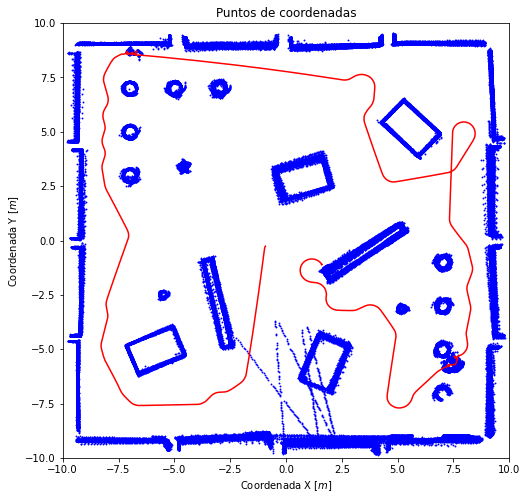

In [85]:
graficar_puntos(coords_c)


# Parte 4


Con las funciones antes desarrolladas, se analiza ahora una serie de mediciones tomadas con un módulo LIDAR real acoplado al robot RomAA, el cual fue desplazado por un recinto cerrado. El procedimiento es igual al realizado en la simulación:

